In [20]:
import time
from datetime import datetime, timedelta
import numpy as np
import os, json

import matplotlib.pyplot as plt

import requests
from pathlib import Path
from earthscope_sdk import EarthScopeClient

client = EarthScopeClient()

def get_token(token_path='./'):

    # refresh the token if it has expired
    client.ctx.auth_flow.refresh_if_necessary()

    token = client.ctx.auth_flow.access_token
    
    return token

def get_es_file(url, directory_to_save_file='./', token_path='./'):

  # get authorization Bearer token
  token = get_token()

  # request a file and provide the token in the Authorization header
  file_name = Path(url).name

  r = requests.get(url, headers={"authorization": f"Bearer {token}"})
  if r.status_code == requests.codes.ok:
    # save the file
    with open(Path(Path(directory_to_save_file) / file_name), 'wb') as f:
        for data in r:
            f.write(data)
  else:
    #problem occured
    print(f"failure: {r.status_code}, {r.reason}")


In [21]:
base_url = "https://api.earthscope.org/beta/discover/gnss/radial?"

latitude = 34.147255
longitude=-103.4073
distance=50
tier="station"
facility="earthscope"
with_information="true"

params = "latitude={}&longitude={}&distance={}&tier={}&facility={}&with_information={}".format(latitude, longitude, distance, tier, facility, with_information)

url = base_url+params

token = get_token()

response = requests.get(url, headers={"authorization": f"Bearer {token}"})

In [22]:
data = response.json()
json_formatted = json.dumps(data, indent=2)
print(json_formatted)


[
  {
    "edid": "01H46MTKV0S5RVXJVG9GG7EQAE",
    "pnum": "PNUM:P038",
    "igs": "IGS:P03800USA",
    "lat": 34.14725482,
    "lon": -103.4073405,
    "elev": 1213.01009
  }
]


In [23]:
# get the station name(s) from 'pnum' key
value = data[0]['pnum']
station = value.split(':')[1].lower()
print(station)

p038


In [24]:
# install georinex  
%pip install georinex

Note: you may need to restart the kernel to use updated packages.


In [25]:
# a list to hold the time to download a file
dl_time=[]

# a list to hold the time to process a file
pr_time=[]

# lists to hold SNR values and the date for each value
snr_list=[]
date_list=[]

# year and starting day to download
year=2025
day = 1

In [26]:
import georinex as gr #https://github.com/geospace-code/georinex/blob/main/Readme_OBS.md

def download_process(doy, year, station, snr_list, date_list):
    two_digit_year=str(year)[2:] #converts integer to string and slices the last characters
    for doy in np.arange(1,10):
        #download
        url='https://gage-data.earthscope.org/archive/gnss/rinex/obs/%d/%03d/%s%03d0.%sd.Z' %(year,doy,station,doy,two_digit_year)
        print('downloading: ', url)
        get_es_file(url, 'rinex_data')
        
        #process
        fn='rinex_data/%s%03d0.%sd.Z' %(station, doy, two_digit_year)
        # Use Georinex to convert Rinex _> Xarray Dataframe
        obs = gr.load(fn, use='G', meas=['S1'])
        g=obs['S1'].mean().values
        snr_list+=[g]
        date_list+=[datetime(year, 1, 1) + timedelta(days=int(doy - 1))]
        #delete the file
        os.remove(fn)
        

In [27]:
start_t = time.time()
download_process(day, year, station, snr_list, date_list)
end_t = time.time()
dl_time=end_t-start_t

snr_rnx=np.mean(snr_list)

downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/001/p0380010.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/002/p0380020.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/003/p0380030.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/004/p0380040.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/005/p0380050.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/006/p0380060.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/007/p0380070.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/008/p0380080.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/009/p0380090.25d.Z


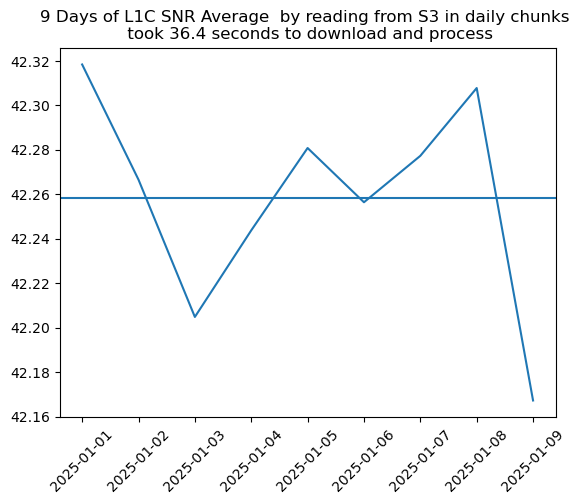

In [28]:
# Plot results ##########
plt.plot(date_list, snr_list)
plt.xticks(rotation=45)
plt.axhline(snr_rnx)
plt.title('%s Days of L1C SNR Average  by reading from S3 in daily chunks \n took %.1f seconds to download and process' %(len(date_list),dl_time))
plt.show()